# Tutorial in using SI wavefront error models in webbpsf

In [1]:
%pylab inline
import webbpsf

matplotlib.rcParams['figure.figsize'] = (10,8)

Populating the interactive namespace from numpy and matplotlib


## Disclaimers

_Note: Prerelease quality. SI WFE maps not yet totally signed off on by SI teams. Needs validation before relase into the wild._ 

_Work in progress! There are probably bugs._

**TODO:**

* Finish implementing NIRCam wavelength dependent focus model
* Test the MIRI field dependent pupil obscuration more
* Develop an interpolation scheme between field points
* Lots of diagnostic plots and documentation

## What does this do and how does it work? 

The goal is putting measured WFE maps from the ISIM CV cryo tests into WebbPSF.

**Initial Dev with CV2 data**: While waiting for the CV3 data to be ready for release from the ISIM Optics group at GSFC, I did essentially all the software development using the CV2 results. 

1. I took the available CV2 wavefront error measurements for the SIs, provided by David Aronstein. These are still relatively noisy at high spatial frequencies, and also suffer from having gaps in the WFE maps due to the holes in the OSIM primary mirror. We don't want to distrubute these actual CV wavefront maps with webbpsf. Too messy. 
2. I developed code to read in the provided data, and adjust coordinates to match the SI pupil orientations needed for webbpsf (i.e. matching the projected OTE exit pupil, in "inverted" orientation). This was cross checked with Randal Telfer to ensure correctness. In the CV2 data, the "tape" artifact provides a convenient fiducial for image handedness which was serendipitously useful for this. 
3. For each field point, I fit Zernike polynomials to the WFE maps, using sufficient Zernikes to get a fit with < 10 nm residuals relative to the measurements. I found that using up to Z=36 worked well enough (i.e. up to the 7th row of the Zernike polynomial triangle). 
4. For each field point, I also obtained the equivalent V2 and V3 angular coordinates. These were easily derived from the X_AN, Y_AN coordinates provided in the FITS headers of the WFE maps. 
5. After repeating that for all available ISIM and MIMF field points I stored the coefficients in a lookup table indexed by instrument and V2V3 coordinates.
6. Each instrument of webbpsf was modified to have a new optical plane which would contain that instrument-internal WFE map. It retrieves the proper Zernikes from the lookup table, generates the WFE map, and adds it to the optical train. 
7. Because all this code went into webbpsf release 0.5, but the data file wasn't public yet, I added a simple switch to turn this functionality on or off. 


The code which implements the import of the WFE maps is available in a Jupyter notebook if anyone wants access to it. For now I just have this in my own files, once there is a final version with all the CV3 data I will put it on central store in the webbpsf data source area. 

**Update with CV3:** Preliminary versions of the CV3 reductions started being delivered by David A. in August 2016. As of 2016 Sept we still don't have NIRSpec data however. 
I was able to basically re-run the CV2 notebook with only minor modifications. 

### Get the necessary data file

You must get the following file and copy it into your webbpsf data directory, i.e. the place that the $WEBBPSF environment variable points, or the webbpsf-data directory inside your Conda setup, depending on how you installed webbpsf. 

Copy this file:

In [2]:
'/grp/jwst/ote/webbpsf_prerelease/si_zernikes_isim_cv3.fits'

'/grp/jwst/ote/webbpsf_prerelease/si_zernikes_isim_cv3.fits'

Into this directory (run the cell to figure out what the appropriate path is on your local machine)

In [3]:
webbpsf.utils.get_webbpsf_data_path()

'/Users/mperrin/software/webbpsf-data'

### An example calculation.

Let's create an instrument instance, and turn on the SI WFE lookup model.  For ease of comparison let's start with a null optical model. Turning off the telescope WFE makes it easier to see the small differences from the instrument internal WFE. 

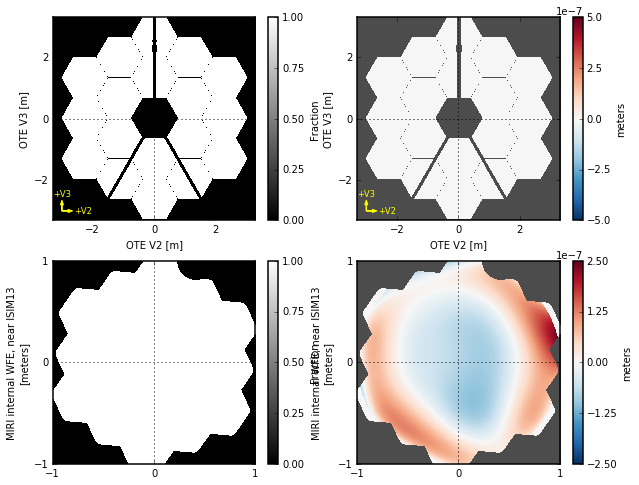

In [5]:
miri = webbpsf.MIRI()
miri.pupilopd = None
miri.display()

For the release 0.5, which lacks the data file in the public data, we turned off this functionality by making the default for `include_si_wfe=False`. Now the default is True to enable it in this dev branch. But you can still turn this WFE on or off for your calculation if you want. 

In [6]:
miri.include_si_wfe = True  # the opposite will turn it off. 

The WFE map depends on the selected pixel position. You can change this by setting the `detector_position` attribute.

For now it just uses the closed match - there is not yet any interpolation done between neighboring points. 

In [7]:
miri.detector_position

(512, 512)

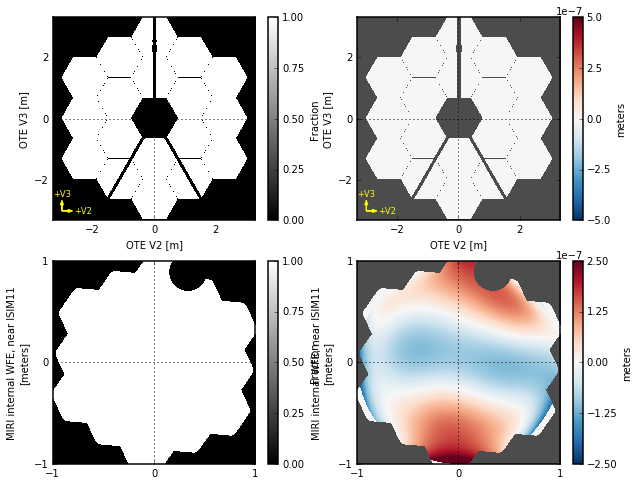

In [8]:
miri.detector_position = (128, 128)
miri.display()

And let's compare some of the output PSFs. The differences are pretty minor in this case. 

In [9]:
miri.detector_position = (512,512)
psf_center = miri.calcPSF()
miri.detector_position = (128,128)
psf_corner = miri.calcPSF()

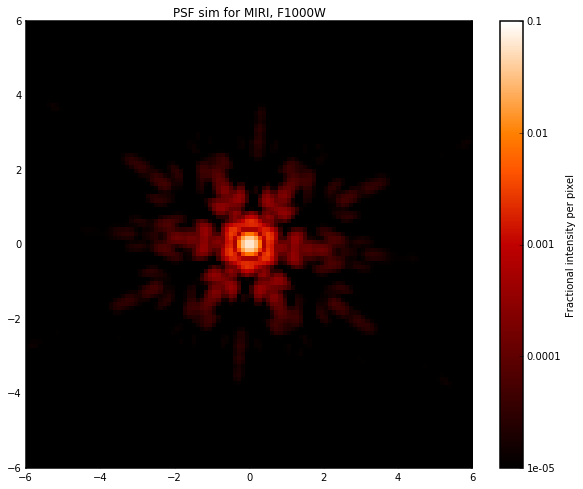

In [10]:
webbpsf.display_psf(psf_center, ext="DET_SAMP", vmin=1e-5)

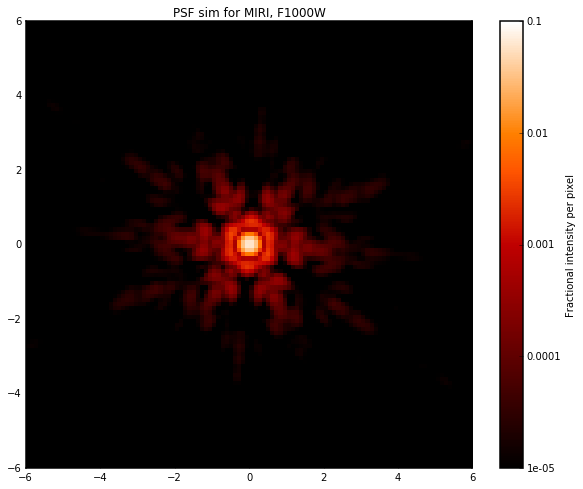

In [11]:
webbpsf.display_psf(psf_corner, ext="DET_SAMP", vmin=1e-5)

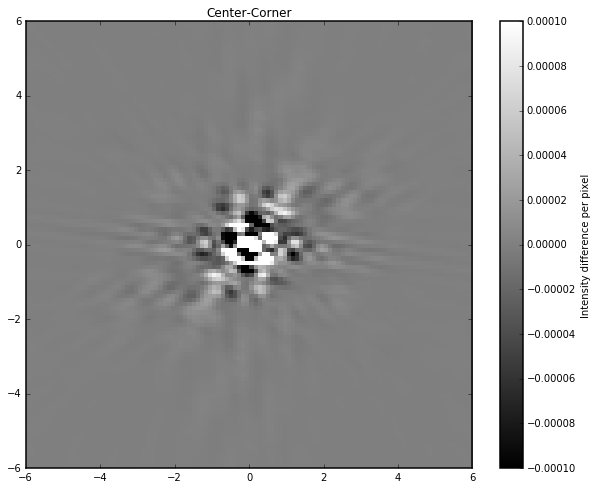

In [12]:
webbpsf.display_psf_difference(psf_center, psf_corner, ext1='DET_SAMP', ext2='DET_SAMP',
                              title='Center-Corner')

## Example with NIRISS

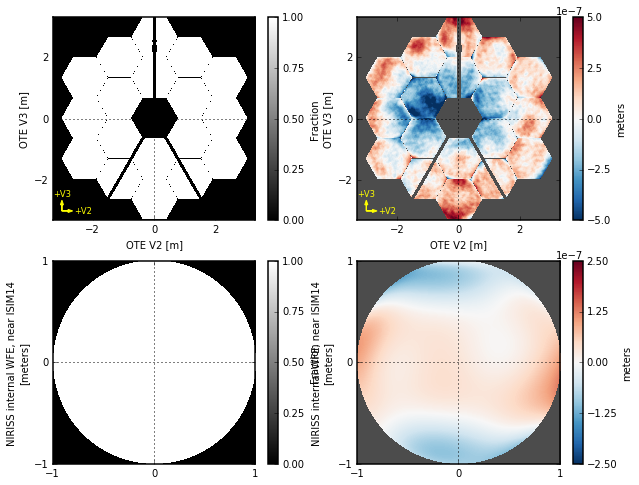

In [13]:
nis = webbpsf.NIRISS()
nis.display()

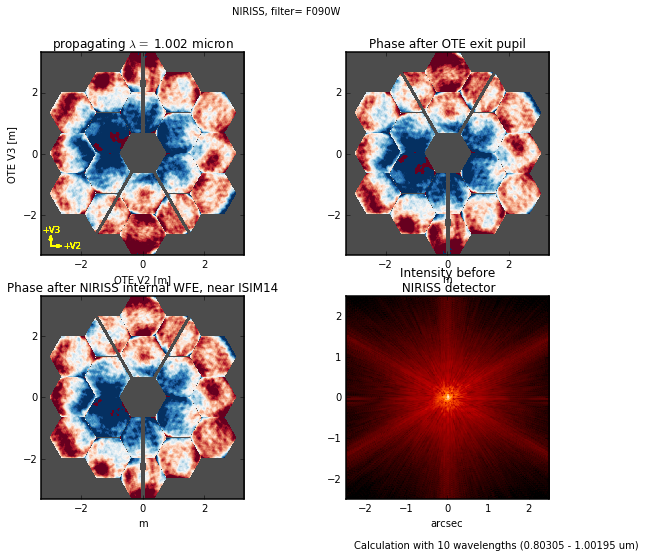

In [14]:
nis.calc_psf(display=True)

It's hard to see much difference there visually... Dominated by the (old) OTE+SI WFE files, which still need to be replaced. 

## Example with NIRCam

DOES NOT WORK YET - NOT FINISHED

In [2]:
nc = webbpsf.NIRCam()
nc.pupilopd = None
nc.include_si_wfe = True

/Users/mperrin/software/macports/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


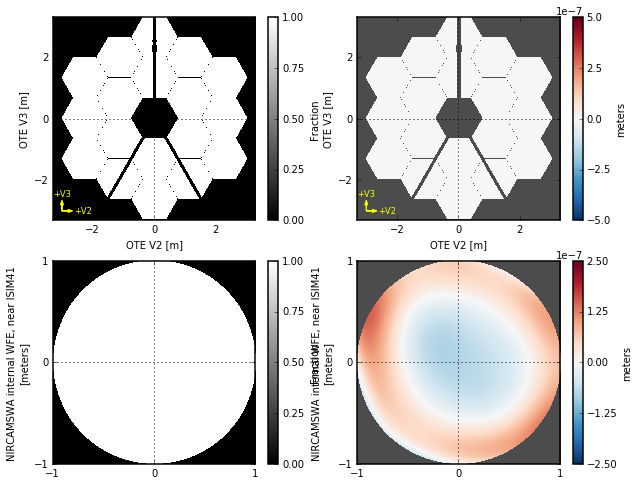

In [3]:
nc.display()

In [4]:
nc.channel, nc.detector, nc.detector_position

('short', 'A1', (1024, 1024))

In [ ]:
nc.detector = 'A1'
psf_a1_center = nc.calcPSF()

In [58]:
nc.detector = 'B3'
psf_b3_center = nc.calcPSF()

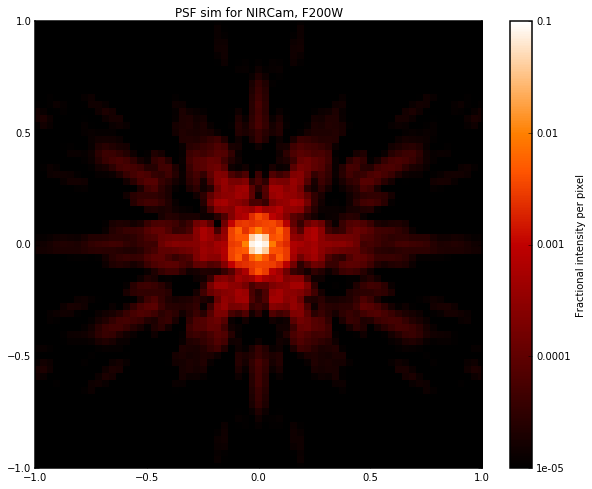

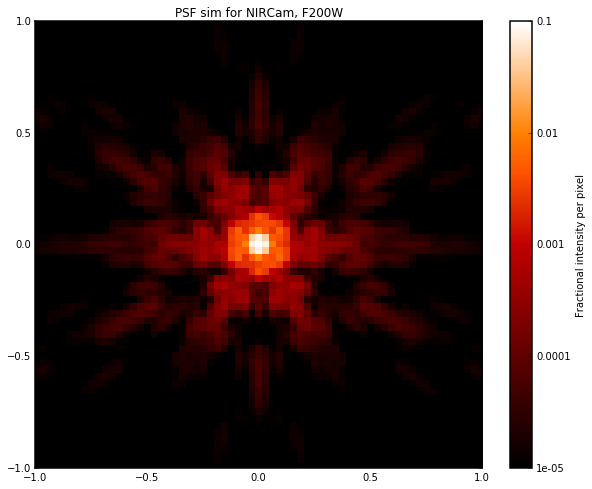

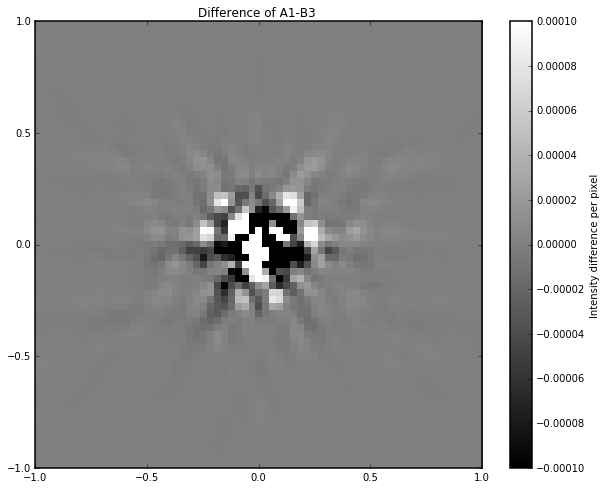

In [60]:
webbpsf.display_psf(psf_a1_center, ext='DET_SAMP', imagecrop=2, vmin=1e-5)
plt.figure()
webbpsf.display_psf(psf_b3_center, ext='DET_SAMP', imagecrop=2, vmin=1e-5)
plt.figure()
webbpsf.display_psf_difference(psf_a1_center,psf_b3_center, ext1='DET_SAMP', ext2='DET_SAMP',
                              title='Difference of A1-B3 ', imagecrop=2)

## Next steps

1. For comparison to CV2/3 data - A first step would be to try using PSFs calculated in this manner, and comparing those to the data. Should be a better fit than the out-of-date WFE maps that are default with webbpsf. 
2. But it oversimplifies to set the telescope WFE to zero. It would be higher fidelity to see if we can get some info for the OSIM WFE (which acts in place of the telescope WFE in this test setup). But that may be overkill depending on the limited fidelity of the available PSFs. 
